# Práctica 1

Autores:
 - Martín de las Heras
 - Daniel Serrano
 
En primer lugar, importamos las librerías que serán necesarias en el transcurso de la práctica:

In [1]:
# Import os and Basis Libraries
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
# Tensflor and Keras Layer and Model and Optimize and Loss
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
# Kernel Intilizer 
from sklearn.preprocessing import LabelEncoder
# import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam, Adamax
# PreTrained Model
from tensorflow.keras.applications import *
from tensorflow.keras.applications import Xception
# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
# Warnings Remove 
import warnings 
warnings.filterwarnings("ignore")
import keras_tuner

2024-04-07 07:31:47.082722: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 07:31:47.082848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 07:31:47.366223: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Cargamos el conjunto de entrenamiento de Kaggle y creamos el *dataframe* que utilizaremos:

In [2]:
directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"

filepath = []
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)
    
    imgs = os.listdir(f_path)
    
    for img in imgs:
        
        img_path = os.path.join(f_path, img)
        filepath.append(img_path)
        label.append(fold)
        
file_path_series = pd.Series(filepath, name = 'filepath')
label_path_series = pd.Series(label, name = 'label')
df_train = pd.concat([file_path_series, label_path_series], axis = 1)

Mostramos unas pocas filas por pantalla:

In [3]:
df_train.head()

,filepath,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA


Repetimos para el conjunto de prueba:

In [4]:
directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

filepath = []
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)
    
    imgs = os.listdir(f_path)
    
    for img in imgs:
        
        img_path = os.path.join(f_path, img)
        filepath.append(img_path)
        label.append(fold)
        
file_path_series = pd.Series(filepath, name = 'filepath')
label_path_series = pd.Series(label, name = 'label')
df_test = pd.concat([file_path_series, label_path_series], axis = 1)

Y de la misma manera, imprimimos por pantalla una muestra del conjunto de prueba:

In [5]:
df_train.sample(5)

,filepath,label
3507,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2224,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3503,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4235,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
2533,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA


Imprimimos por pantalla las dimensiones de los conjuntos de entrenamiento y prueba:

In [6]:
print(f"Las dimensiones del conjunto de entrenamiento son: {df_train.shape}")
print(f"Las dimensiones del conjunto de prueba son: {df_test.shape}")

Las dimensiones del conjunto de entrenamiento son: (5216, 2)
Las dimensiones del conjunto de prueba son: (624, 2)


---

## Creamos los *datasets* de entrenamiento, validación y test

In [7]:
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

IMAGE_SIZE = (256,256)

print('Imágenes de entrenamiento:')
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('Imágenes de validación:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('Imágenes de prueba:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

Imágenes de entrenamiento:
Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Imágenes de validación:
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Imágenes de prueba:
Found 624 files belonging to 2 classes.


## Codificar etiquetas

A continuación, utilizaremos el *LabelEncoder* para codificar las categorías de las imágenes:

In [8]:
train_labels = train_ds.class_names
validation_labels = validation_ds.class_names
test_labels = test_ds.class_names

class_labels = ['NORMAL', 'PNEUMONIA'] 

label_encoder = LabelEncoder()
label_encoder.fit(class_labels)

train_labels_encoded = label_encoder.transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)
test_labels_encoded = label_encoder.transform(test_labels)

De la misma manera, imprimios por pantalla las dimensiones de las entradas del conjunto de entrenamiento:

In [9]:
for image_batch, labels_batch in train_ds:
    print("Shape of X_train: ", image_batch.shape)
    print("Shape of y_train: ", labels_batch.shape)
    break

Shape of X_train:  (32, 256, 256, 3)
Shape of y_train:  (32,)


## Normalizar Valores Pixel

Normalizamos los valores de los pixels dividiendo por 255:

In [10]:
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

## Métricas conjuntos

Hacemos un estudio previo del conjunto de datos de entrenamiento para ver qué es necesario tener en cuenta de cara al procesado de los mismos. Para ello contamos las ocurrencias de cada etiqueta en el *dataframe* y graficamos los resultados.

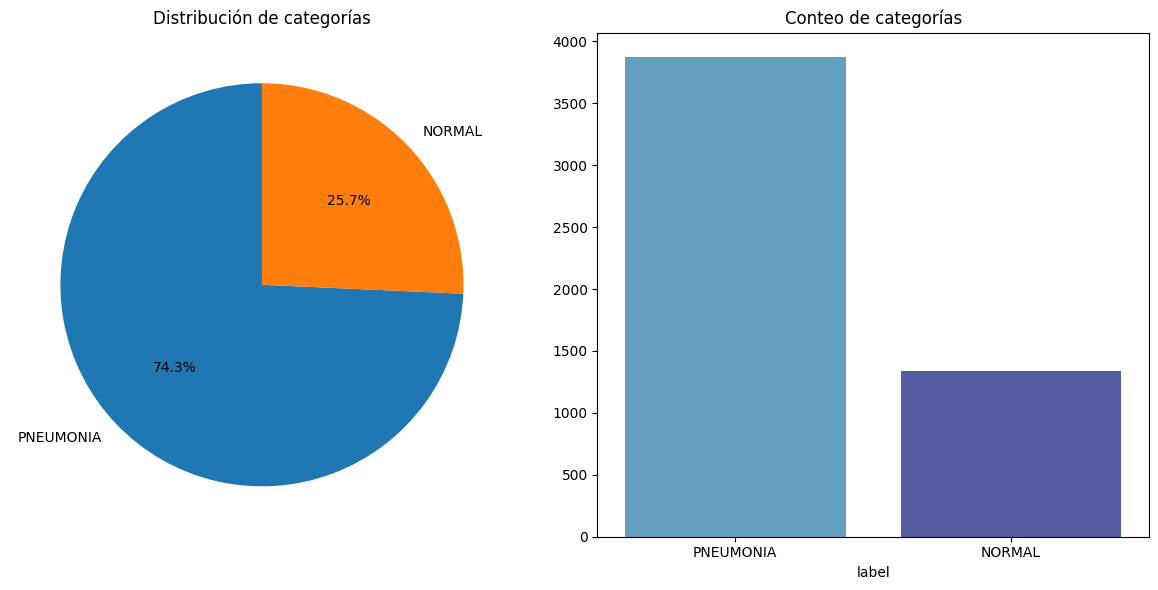

In [11]:
count = df_train['label'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

palette = sns.color_palette("icefire")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Distribución de categorías')

sns.barplot(x=count.index, y=count.values, ax=axs[1])
axs[1].set_title('Conteo de categorías')

plt.tight_layout()
plt.show()

Repetimos el estudio con el conjunto de datos de prueba.

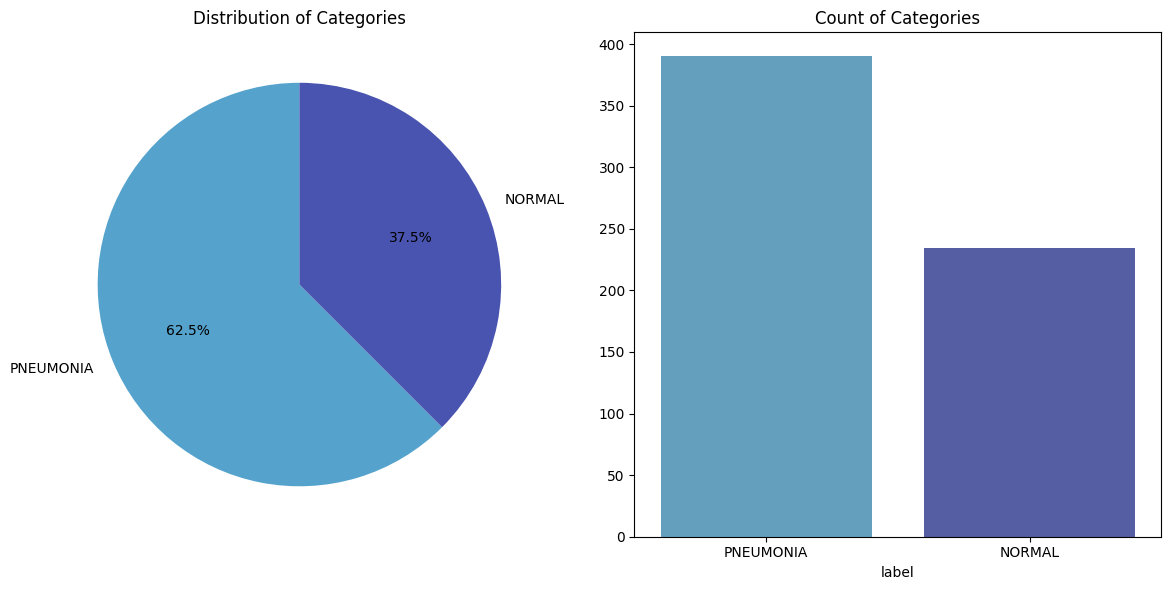

In [12]:
count = df_test['label'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

palette = sns.color_palette("icefire")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Distribution of Categories')

sns.barplot(x=count.index, y=count.values, ax=axs[1])
axs[1].set_title('Count of Categories')

plt.tight_layout()
plt.show()

---
## Visualización imágenes de entrenamiento

Extraemos y mostramos por pantalla 5 imágenes del conjunto de entrenamiento. Para ello, en primer lugar, definimos una función de visualización.

In [13]:
def visualize_images(path, num_images=5):
    image_filenames = os.listdir(path)
    
    num_images = min(num_images, len(image_filenames))
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')
    
    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)
    
    plt.tight_layout()
    plt.show()

## NORMAL Imágenes

Imprimimos imágenes calificadas como *NORMAL*

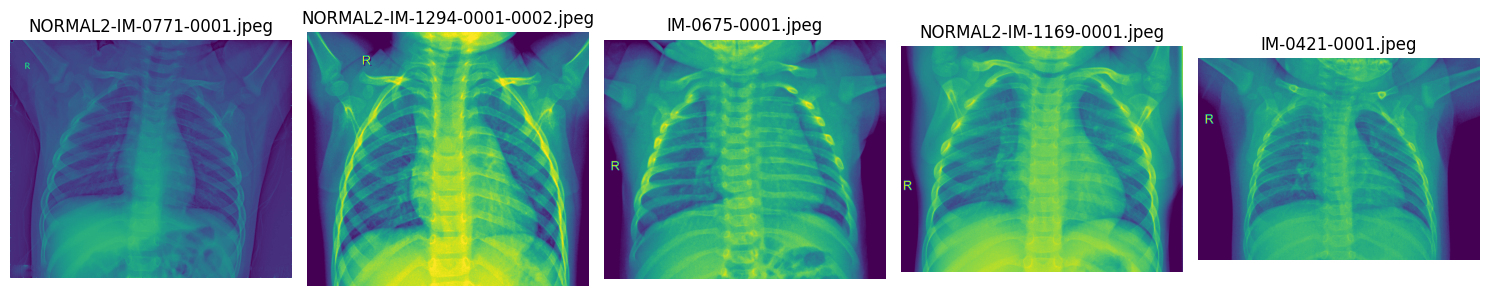

In [14]:
path_to_visualize = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"

visualize_images(path_to_visualize, num_images=5)

## PNEUMONIA Imágenes

Imprimimos imágenes calificadas como *PNEUMONIA*

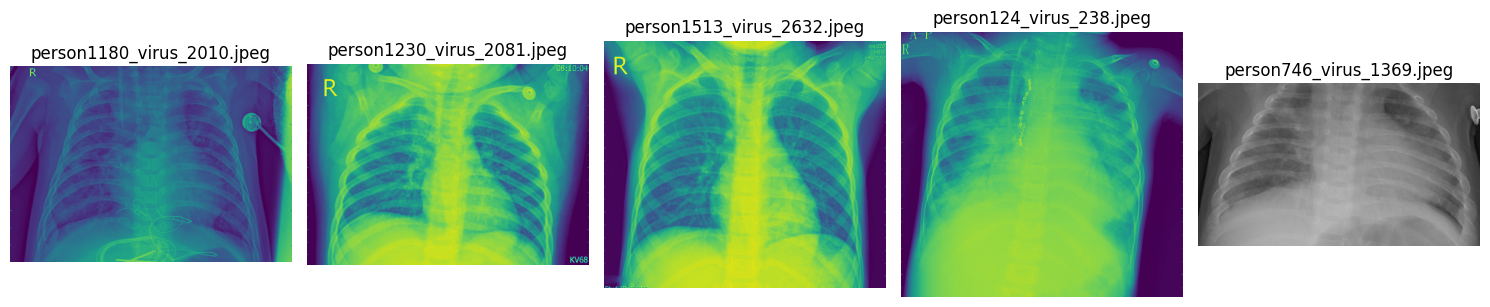

In [15]:
path_to_visualize = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

visualize_images(path_to_visualize, num_images=5)

---
# Definición de los modelos

En esta práctica, tomaremos dos enfoques de cara a la clasificación:
 1. Red Neuronal Profunda con 3 capas ocultas
 2. Red Neuronal Profunda con 2 capas ocultas

## 1. Red Neuronal Profunda con 3 capas ocultas

En primer lugar, tomaremos una red neuronal profunda, a la cual le pasaremos las imágenes como array de pixeles con el valor de la escala de grises (evitamos el color ya que va a hacer que nuestro modelo sea mucho más lento).

Para ello hemos optado en primer lugar por una arquitectura de 3 capas ocultas cuyos valores de número de neuronas será decidido por un afinador de hiperparámetros, estas capas tienen un *dropout* de 0.25 en las dos últimas. De la misma manera, utilizamos el afinador para elegir la función de activación, pudiendo elegir entre *relu* y *tanh* y el *learning rate* se escoge de la misma manera.

Hemos optado por esta elección de hiperparámetros para poder ver los distintos valores que resultan de este proceso sin tener que ajustarlos de manera manual a cada ejecución.

In [16]:
def call_existing_code(units, units_2, units_3, activation, lr):
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=[256,256,3]))
    model.add(tf.keras.layers.Flatten()) 

    model.add(Dense(units, activation=activation))

    model.add(Dropout(0.25))
    model.add(Dense(units_2, activation=activation))

    model.add(Dropout(0.25)) 
    model.add(Dense(units_3,activation=activation))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adamax(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


def build_model(hp):
    units = hp.Int("units", min_value=256, max_value=512, step=64)
    units_2 = hp.Int("units_2", min_value=128, max_value=256, step=32)
    units_3 = hp.Int("units_3", min_value=32, max_value=128, step=16)
    
    activation = hp.Choice("activation", ["relu", "tanh"])
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(
        units=units, units_2=units_2, units_3=units_3, activation=activation, lr=lr
    )
    return model

build_model(keras_tuner.HyperParameters())

<Sequential name=sequential, built=True>

Uan vez definidas tanto la red como la función de afinamiento de los hiperparámetros, definimos la variable que se encargará de realizar la búsqueda aleatoria de los hiperparámetros, imprimimos por pantalla un resumen de los espacios numéricos donde va a buscar los mismos, y efectuamos la búsqueda. En esta búsqueda se realizan 10 intentos de 2 ejecuciones cada uno, consistiendo de 2 épocas respectivamente. Tras esto almacenamos los datos de los hiperparámetros escogidos por la búsqueda.

In [17]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="deeplearning",
)

In [18]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [19]:
tuner.search(
    train_ds, 
    epochs=2, 
    validation_data=validation_ds,
    callbacks=[keras.callbacks.TensorBoard("my_dir/tb_logs")],
);

Trial 10 Complete [00h 01m 41s]
val_accuracy: 0.7639155387878418

Best val_accuracy So Far: 0.9213051795959473
Total elapsed time: 00h 17m 00s


Se puede observar que los datos los hemos almacenado mediante un *framework* llamado TensorBoard. Se trata de una herramienta de visualización de datos.

Escogemos los dos mejores modelos e imprimimos por pantalla sus métricas:

In [20]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()
second_best_model = models[1]
second_best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    50,331,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 48)             │         6,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,371,041 (192.15 MB)

 Trainable params: 50,371,041 (192.15 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │    62,914,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 160)            │        51,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,986,977 (240.28 MB)

 Trainable params: 62,986,977 (240.28 MB)

 Non-trainable params: 0 (0.00 B)

De la misma manera, escribimos por pantalla un resumen del proceso de afinado y obtenemos los dos mejores conjuntos de hiperparámetros:

In [21]:
tuner.results_summary()

Results summary
Results in my_dir/deeplearning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
units: 256
units_2: 128
units_3: 48
activation: relu
lr: 0.0007938551864387135
Score: 0.9213051795959473

Trial 01 summary
Hyperparameters:
units: 320
units_2: 160
units_3: 128
activation: relu
lr: 0.0009773430262285175
Score: 0.9069097638130188

Trial 02 summary
Hyperparameters:
units: 448
units_2: 128
units_3: 128
activation: relu
lr: 0.0025510751612212845
Score: 0.9021113216876984

Trial 05 summary
Hyperparameters:
units: 384
units_2: 224
units_3: 96
activation: relu
lr: 0.008212458838617381
Score: 0.8829174637794495

Trial 00 summary
Hyperparameters:
units: 384
units_2: 128
units_3: 80
activation: tanh
lr: 0.000212916243290288
Score: 0.7639155387878418

Trial 03 summary
Hyperparameters:
units: 448
units_2: 224
units_3: 80
activation: tanh
lr: 0.00013404995709128298
Score: 0.7639155387878418

Trial 04 summary
Hyperparameters:
units:

In [22]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])

### 1.1 Compilar y Entrenar

Definimos un *early stopping* de cara al entrenamiento de la red neuronal, guardando siempre la mejor ejecución y definiendo una paciencia de 5 *epochs*. A continuación, la entrenamos con el conjunto de entrenamiento validando con el de validación:

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_ds,
          epochs= 20,
          validation_data = validation_ds,
          callbacks = early_stopping);

Epoch 1/20
  7/147 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6006 - loss: 12.3452

W0000 00:00:1712476170.981262      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6899 - loss: 5.5551

W0000 00:00:1712476190.714593      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712476191.552624      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/147 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - accuracy: 0.6903 - loss: 5.5349 - val_accuracy: 0.9117 - val_loss: 0.2118
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.8785 - loss: 0.3033 - val_accuracy: 0.9347 - val_loss: 0.1598
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.8847 - loss: 0.2869 - val_accuracy: 0.9443 - val_loss: 0.1509
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.9064 - loss: 0.2389 - val_accuracy: 0.9578 - val_loss: 0.1244
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.9076 - loss: 0.2400 - val_accuracy: 0.9501 - val_loss: 0.1264
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.8849 - loss: 0.2441 - val_accuracy: 0.7639 - val_loss: 0.2322
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.8782 - loss: 0.2631 - val_accuracy: 0.9539 - val_loss: 0.1019
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.8868 - loss: 0.2322 - val

### 1.2 Error de validación y precisión

Obtenemos el error sobre el conjunto de validación y su precisión sobre el mismo:

In [24]:
validation_loss, validation_accuracy = model.evaluate(validation_ds)

print("Error de validación:", validation_loss)
print("Precisión:", validation_accuracy)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9529 - loss: 0.0905
Error de validación: 0.11625275015830994
Precisión: 0.9539347290992737


Ahora, escogemos la época con mejor precisión y graficamos tanto la precisión como la función de pérdida de los conjuntos de entrenamiento y validación:

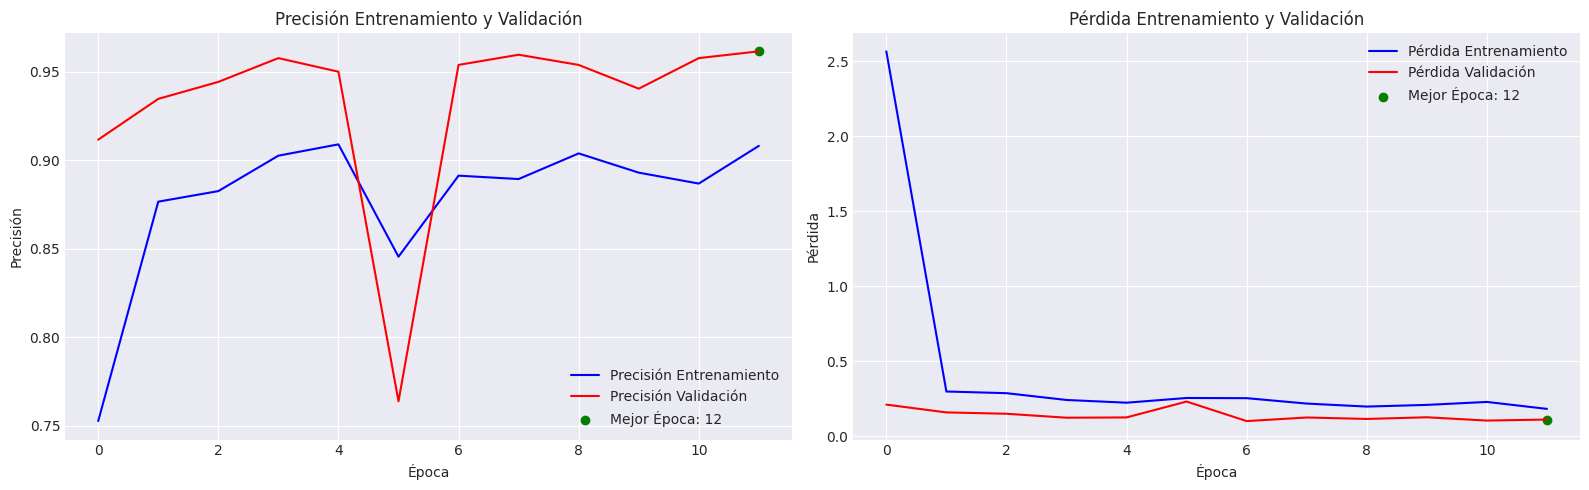

In [25]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

plt.style.use('seaborn-darkgrid')
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(history.history['accuracy'], label='Precisión Entrenamiento', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Precisión Validación', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Mejor Época: {best_epoch}')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Precisión')
axs[0].set_title('Precisión Entrenamiento y Validación')
axs[0].legend()

axs[1].plot(history.history['loss'], label='Pérdida Entrenamiento', color='blue')
axs[1].plot(history.history['val_loss'], label='Pérdida Validación', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Mejor Época: {best_epoch}')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Pérdida')
axs[1].set_title('Pérdida Entrenamiento y Validación')
axs[1].legend()

plt.tight_layout()
plt.show()

### 1.3 Predicciones del Modelo

Por último, tomamos una muestra de imágenes del conjunto de test e imprimimos por pantalla tanto las imágenes como las predicciones del modelo.

Para ello, en primer lugar definimos una función que nos imprima por pantalla:

In [26]:
def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    predictions = model.predict(dataset)
    
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))
    
    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        images = images.numpy()
        
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]
                
                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))  
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

Testing Images:
Found 624 files belonging to 2 classes.
Testing Images:
 3/20 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

W0000 00:00:1712476417.977628      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step


W0000 00:00:1712476420.067447      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


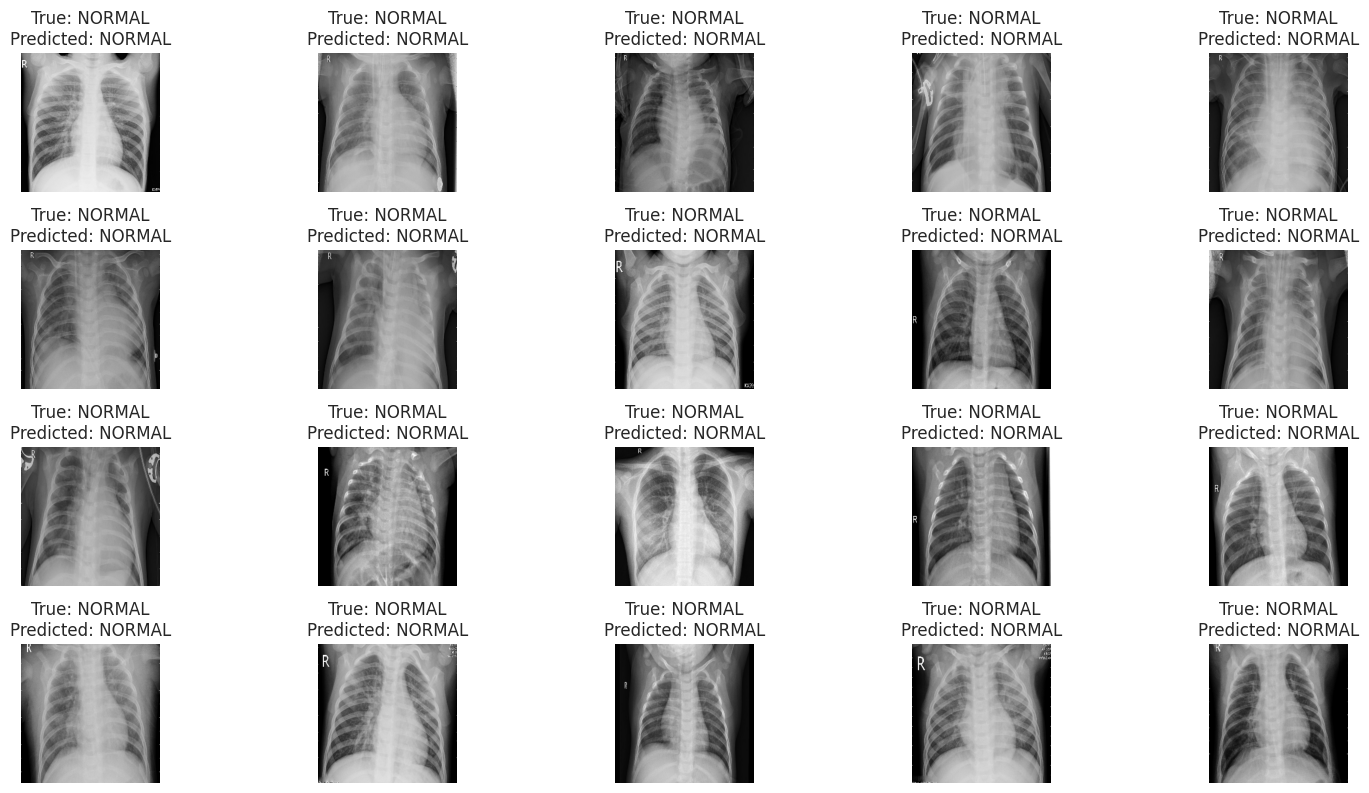

In [27]:
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'
print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    predictions = model.predict(dataset)
    
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))
    
    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        images = images.numpy()
        
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]
                
                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))  
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

print('Testing Images:')
plot_images_with_predictions(model, test_ds, class_labels, num_images=20)

Dado que es un conjunto ligeramente desbalanceado, imprimiremos por pantalla ahora solamente imágenes que están clasificadas como *PNEUMONIA*, para ver cómo se comporta el modelo sobre ellas:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


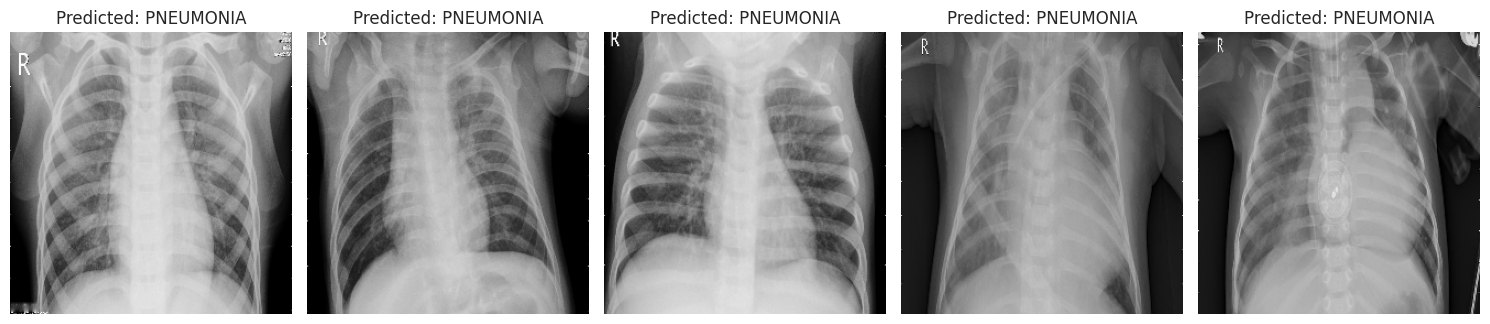

In [28]:
directory_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'

image_files = os.listdir(directory_path)[:5]

fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))

for i, image_file in enumerate(image_files):
    img_path = os.path.join(directory_path, image_file)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256)) 

    img_array = img.astype(np.float32) / 255.0  

    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    actual_prediction = (predictions > 0.5).astype(int)

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
    axs[i].axis('off')
    if actual_prediction[0][0] == 0:
        predicted_label = 'Normal'
    else:
        predicted_label = 'PNEUMONIA'
    axs[i].set_title(f'Predicted: {predicted_label}')

plt.tight_layout()
plt.show()

---

## 2. Red Neuronal Profunda con 2 capas ocultas

A continuación, repetimos el procedimiento con una red neuronal más reducida, la cual contará con solamente 2 capas ocultas. Para ello eliminamos la capa intermedia de las que teníamos antes, reajustando el código como sea necesario:

In [29]:
def call_existing_code(units, units_2, activation, lr):
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=[256,256,3]))
    model.add(tf.keras.layers.Flatten()) 

    model.add(Dense(units, activation=activation))

    model.add(Dropout(0.25))
    model.add(Dense(units_2, activation=activation))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adamax(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


def build_model(hp):
    units = hp.Int("units", min_value=256, max_value=512, step=64)
    units_2 = hp.Int("units_2", min_value=32, max_value=128, step=16)
    
    activation = hp.Choice("activation", ["relu", "tanh"])
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(
        units=units, units_2=units_2, activation=activation, lr=lr
    )
    return model

build_model(keras_tuner.HyperParameters())

<Sequential name=sequential_2, built=True>

Repetimos los mismos pasos que en el experimento anterior:

In [30]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="deeplearning",
)

In [31]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [32]:
tuner.search(
    train_ds, 
    epochs=2, 
    validation_data=validation_ds,
    callbacks=[keras.callbacks.TensorBoard("my_dir/tb_logs")],
);

Trial 10 Complete [00h 01m 30s]
val_accuracy: 0.7639155387878418

Best val_accuracy So Far: 0.951055645942688
Total elapsed time: 00h 17m 29s


Escogemos los dos mejores modelos e imprimimos por pantalla sus métricas:

In [33]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()
second_best_model = models[1]
second_best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 448)            │    88,080,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,138,433 (336.22 MB)

 Trainable params: 88,138,433 (336.22 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 448)            │    88,080,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │        21,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,102,433 (336.08 MB)

 Trainable params: 88,102,433 (336.08 MB)

 Non-trainable params: 0 (0.00 B)

De la misma manera, escribimos por pantalla un resumen del proceso de afinado y obtenemos los dos mejores conjuntos de hiperparámetros:

In [34]:
tuner.results_summary()

Results summary
Results in my_dir/deeplearning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
units: 448
units_2: 128
activation: relu
lr: 0.0002486232455031409
Score: 0.951055645942688

Trial 07 summary
Hyperparameters:
units: 448
units_2: 48
activation: relu
lr: 0.00026216574533731863
Score: 0.9481765627861023

Trial 01 summary
Hyperparameters:
units: 512
units_2: 80
activation: relu
lr: 0.0003003919158279524
Score: 0.938579648733139

Trial 04 summary
Hyperparameters:
units: 512
units_2: 64
activation: relu
lr: 0.00025349154587181233
Score: 0.9376199543476105

Trial 06 summary
Hyperparameters:
units: 384
units_2: 32
activation: relu
lr: 0.0009328604664075379
Score: 0.9376199543476105

Trial 02 summary
Hyperparameters:
units: 512
units_2: 32
activation: relu
lr: 0.003993492840731953
Score: 0.7639155387878418

Trial 03 summary
Hyperparameters:
units: 512
units_2: 48
activation: tanh
lr: 0.006683401779428952
Score: 0.76391553878

In [35]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])

### 2.1 Compilar y Entrenar

Definimos un *early stopping* de cara al entrenamiento de la red neuronal, guardando siempre la mejor ejecución y definiendo una paciencia de 5 *epochs*. A continuación, la entrenamos con el conjunto de entrenamiento validando con el de validación:

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_ds,
          epochs= 20,
          validation_data = validation_ds,
          callbacks = early_stopping);

Epoch 1/20
  5/147 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.4114 - loss: 10.3786

W0000 00:00:1712477488.150322      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6842 - loss: 3.4191

W0000 00:00:1712477505.782365      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712477507.022038      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712477507.860590      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - accuracy: 0.6847 - loss: 3.4075 - val_accuracy: 0.9175 - val_loss: 0.1791
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.8630 - loss: 0.4781 - val_accuracy: 0.8906 - val_loss: 0.2915
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.9018 - loss: 0.2861 - val_accuracy: 0.8983 - val_loss: 0.2620
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.9154 - loss: 0.2225 - val_accuracy: 0.9482 - val_loss: 0.1286
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.9308 - loss: 0.1832 - val_accuracy: 0.9559 - val_loss: 0.1071
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9302 - loss: 0.1757 - val_accuracy: 0.9482 - val_loss: 0.1282
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.9312 - loss: 0.1783 - val_accuracy: 0.9578 - val_loss: 0.1143
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.9271 - loss: 0.1875 - val

### 2.2 Error de validación y precisión

Obtenemos el error sobre el conjunto de validación y su precisión sobre el mismo:

In [37]:
validation_loss, validation_accuracy = model.evaluate(validation_ds)

print("Error de validación:", validation_loss)
print("Precisión:", validation_accuracy)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9639 - loss: 0.1009
Error de validación: 0.10180738568305969
Precisión: 0.9635316729545593


Ahora, escogemos la época con mejor precisión y graficamos tanto la precisión como la función de pérdida de los conjuntos de entrenamiento y validación:

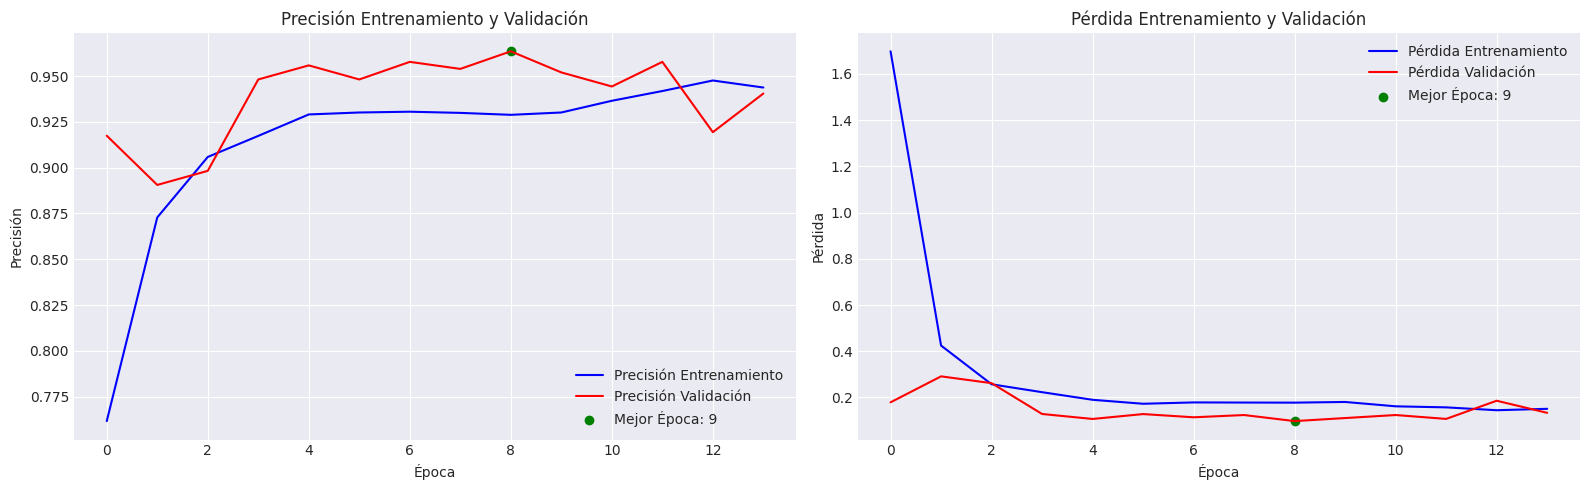

In [38]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

plt.style.use('seaborn-darkgrid')
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(history.history['accuracy'], label='Precisión Entrenamiento', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Precisión Validación', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Mejor Época: {best_epoch}')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Precisión')
axs[0].set_title('Precisión Entrenamiento y Validación')
axs[0].legend()

axs[1].plot(history.history['loss'], label='Pérdida Entrenamiento', color='blue')
axs[1].plot(history.history['val_loss'], label='Pérdida Validación', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Mejor Época: {best_epoch}')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Pérdida')
axs[1].set_title('Pérdida Entrenamiento y Validación')
axs[1].legend()

plt.tight_layout()
plt.show()

### 2.3 Predicciones del Modelo

Por último, tomamos una muestra de imágenes del conjunto de test e imprimimos por pantalla tanto las imágenes como las predicciones del modelo.

Para ello, en primer lugar definimos una función que nos imprima por pantalla:

In [39]:
def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    predictions = model.predict(dataset)
    
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))
    
    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        images = images.numpy()
        
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]
                
                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))  
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

Testing Images:
Found 624 files belonging to 2 classes.
Testing Images:
 3/20 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

W0000 00:00:1712477777.094135      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step


W0000 00:00:1712477778.672565      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


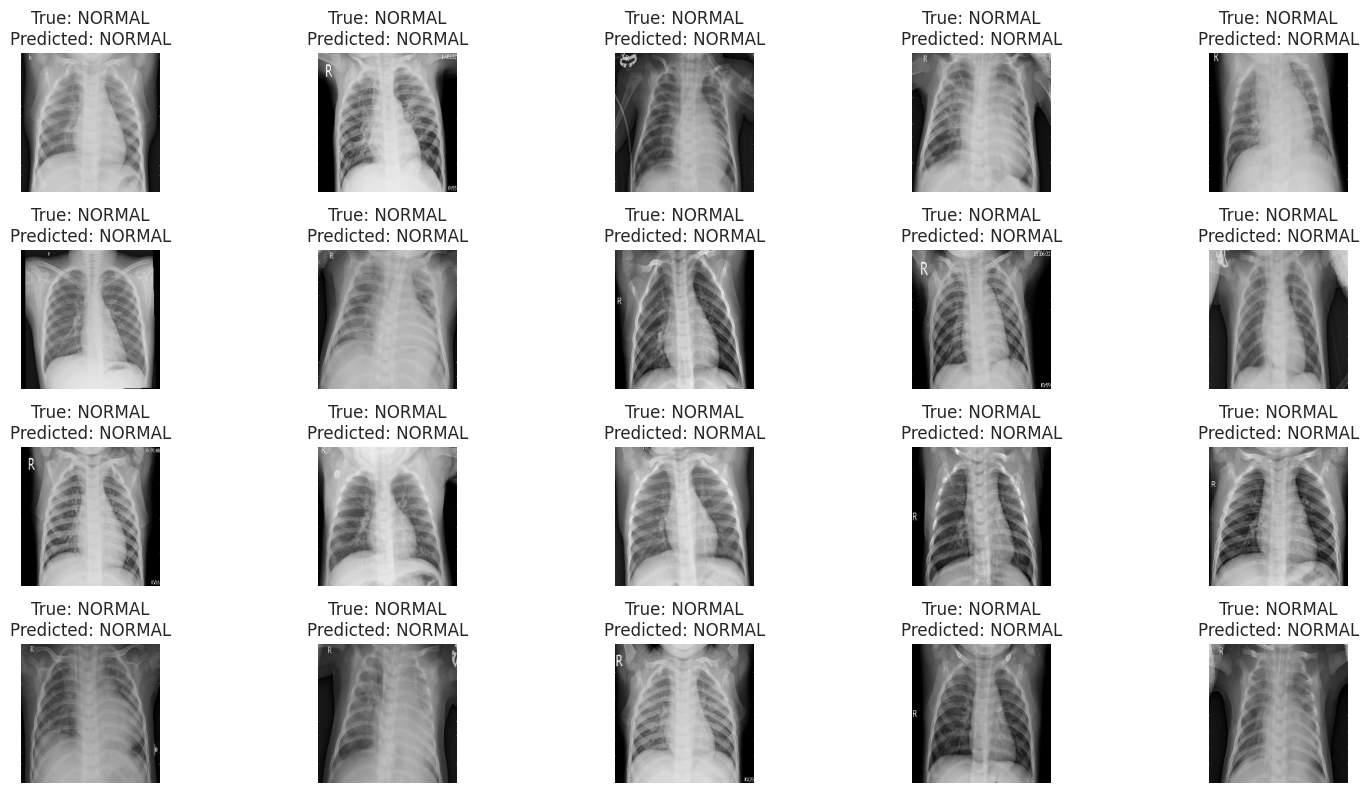

In [40]:
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'
print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    predictions = model.predict(dataset)
    
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))
    
    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        images = images.numpy()
        
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]
                
                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))  
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

print('Testing Images:')
plot_images_with_predictions(model, test_ds, class_labels, num_images=20)

Dado que es un conjunto ligeramente desbalanceado, imprimiremos por pantalla ahora solamente imágenes que están clasificadas como *PNEUMONIA*, para ver cómo se comporta el modelo sobre ellas:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


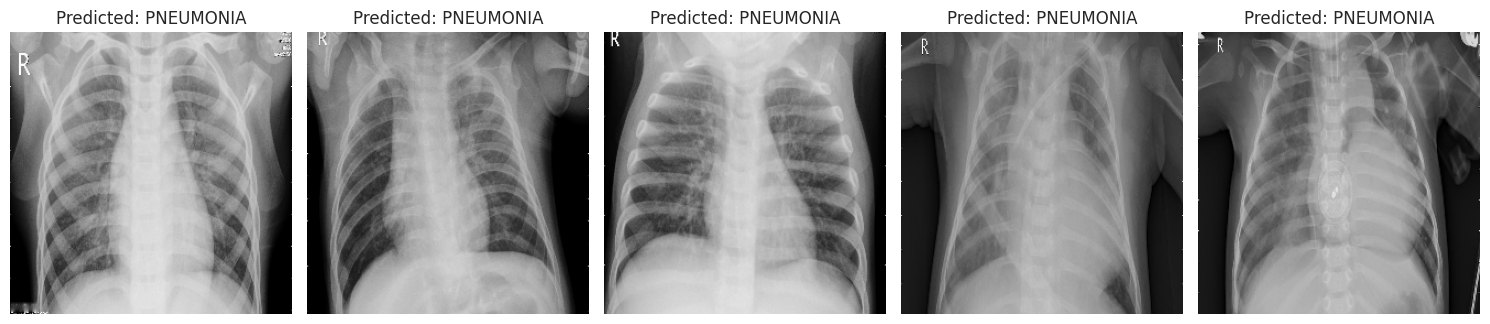

In [41]:
directory_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'

image_files = os.listdir(directory_path)[:5]

fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))

for i, image_file in enumerate(image_files):
    img_path = os.path.join(directory_path, image_file)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256)) 

    img_array = img.astype(np.float32) / 255.0  

    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    actual_prediction = (predictions > 0.5).astype(int)

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
    axs[i].axis('off')
    if actual_prediction[0][0] == 0:
        predicted_label = 'Normal'
    else:
        predicted_label = 'PNEUMONIA'
    axs[i].set_title(f'Predicted: {predicted_label}')

plt.tight_layout()
plt.show()

## 3. Conclusiones

Hemos podido ver que, no solo la segunda red neuronal es capaz de predecir con un porcentaje de acierto mayor sino que también ha sido considerablemente más barato su entrenamiento. Esto se debe a que la primera red está sobreajustada, de manera que se "aprende" los datos de entrenamiento, pero luego le cuesta más generalizar a imágenes que no ha visto nunca. De la misma manera, hemos visto cómo las distintas combinaciones de hiperparámetros producen resultados muy distintos de cara al modelo resultante, así como una manera de ajustarlos para obtener los mejores resultados posibles.

Como hemos dado en clase, sabemos que esta no es la mejor implementación de cara a una clasificación de imágenes, que redes como las convolucionales, o métodos como el *transfer learning* producen mejores resultados con menos recursos. Estas implementaciones formarán parte de la siguiente práctica, donde veremos cómo mejoran tanto los resultados como la eficiencia a la hora de entrenar los modelos.